In [1]:
# %%
import os


os.environ["JAX_PLATFORMS"] = "cuda"  # change to 'cpu' if no GPU is available


from datasets import load_dataset

import grain

import jax
from jax import numpy as jnp

import numpy as np

from flax import nnx

from gensbi.experimental.models.autoencoders import AutoEncoder1D, AutoEncoderParams, vae_loss_fn
from gensbi.experimental.models.autoencoders.commons import Loss

import optax

from tqdm import tqdm

import matplotlib.pyplot as plt

from gensbi.utils.plotting import plot_marginals

In [2]:
repo_name = "aurelio-amerio/SBI-benchmarks"

task_name = "gravitational_waves"

# dataset = load_dataset(repo_name, task_name).with_format("numpy")
dataset = load_dataset(repo_name, task_name, cache_dir="/data/users/.cache").with_format("numpy")


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [3]:
# df_train = {"xs": np.array(dataset["train"]["xs"]), "thetas": np.array(dataset["train"]["thetas"])}
# df_val = {"xs": np.array(dataset["validation"]["xs"]), "thetas": np.array(dataset["validation"]["thetas"])}
# df_test = {"xs": np.array(dataset["test"]["xs"]), "thetas": np.array(dataset["test"]["thetas"])}
df_train = dataset["train"]
df_val = dataset["validation"]
df_test = dataset["test"]

In [ ]:
# compute the mean of xs and thetas
xs_mean = np.mean(df_train["xs"], axis=(0,1), keepdims=True)
thetas_mean = np.mean(df_train["thetas"], axis=0, keepdims=True)

xs_std = np.std(df_train["xs"], axis=(0,1), keepdims=True)
thetas_std = np.std(df_train["thetas"], axis=0, keepdims=True)


In [ ]:
def normalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return (batch - mean) / std

def unnormalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return batch * std + mean

In [8]:
def get_obs(batch):
    xs = jnp.array(batch["xs"],dtype=jnp.bfloat16)
    return normalize(xs, xs_mean, xs_std)

In [9]:
train_dataset = (
            grain.MapDataset.source(df_train)
            .shuffle(42)
            .repeat()
            .to_iter_dataset()
            .batch(128)
            .map(get_obs)
            # .mp_prefetch()
        )

val_dataset = (
            grain.MapDataset.source(df_val)
            .shuffle(42)
            .repeat()
            .to_iter_dataset()
            .batch(128)
            .map(get_obs)
        )

In [10]:
train_iter = iter(train_dataset)
val_iter = iter(val_dataset)

In [11]:
batch = next(train_iter)

In [12]:
next(train_iter).shape, next(val_iter).shape

((128, 8192, 2), (128, 8192, 2))

In [19]:
# ae_params = AutoEncoderParams(
#         resolution=8192,
#         in_channels=2,
#         ch=32,
#         out_ch=2,
#         ch_mult=[
#             1,  # 8192
#             2,  # 4096
#             4,  # 2048
#             8,  # 1024
#             16, # 512
#             16, # 256
#             16, # 128
#             16, # 64
#             #  16, # 32
#             #  16, # 16
#             #  16 # 8
#         ],
#         num_res_blocks=1,
#         z_channels=512,
#         scale_factor=0.3611,
#         shift_factor=0.1159,
#         rngs=nnx.Rngs(42),
#         param_dtype=jnp.bfloat16,
#     )
ae_params = AutoEncoderParams(
        resolution=8192,
        in_channels=2,
        ch=32,
        out_ch=2,
        ch_mult=[
            1,  # 8192
            2,  # 4096
            4,  # 2048
            6,  # 1024
            16,  # 512
            16, # 256
            16, # 128
            16, # 64
            # 16, # 32
            # 16, # 16
            # 16, # 8
            # 16, # 4
        ],
        num_res_blocks=1,
        z_channels=512,
        scale_factor=0.3611,
        shift_factor=0.1159,
        rngs=nnx.Rngs(42),
        param_dtype=jnp.bfloat16,
    )

In [20]:
training_config = VAE1DPipeline._get_default_training_config()
training_config["checkpoint_dir"] = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/tests/gw_vae/checkpoints"

# %%
pipeline = VAE1DPipeline(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    params=ae_params,
    training_config=training_config,
)

In [21]:
pipeline.restore_model(2)

Restored model from checkpoint


In [41]:
# an observation for testing
x_o = df_val["xs"][5][None,...]
x_o_norm = normalize(jnp.array(x_o,dtype=jnp.bfloat16), xs_mean, xs_std)

In [42]:
# %%
pred = pipeline.model(x_o_norm)
# we need to unnormalize the prediction and observation
pred_unnorm = unnormalize(pred, xs_mean, xs_std)
x_o_unnorm = unnormalize(x_o_norm, xs_mean, xs_std)

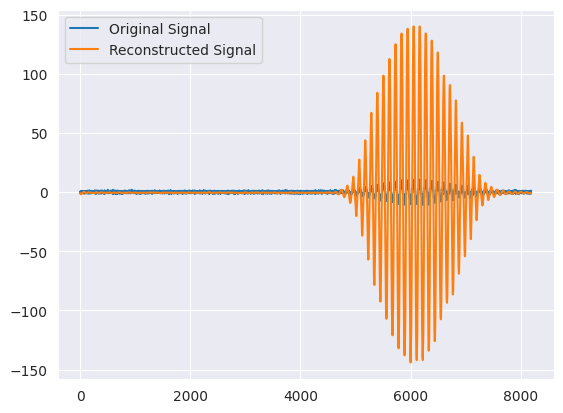

: 

In [ ]:
idx = 0
plt.plot(x_o_norm[idx,:,0], label="Original Signal")
plt.plot(pred[idx,:,0], label="Reconstructed Signal")
plt.legend()
plt.show()

# now we create the flow pipeline

In [16]:
from gensbi.models import Flux1Params
from gensbi.recipes import Flux1FlowPipeline

In [17]:
dim_obs = 1
dim_cond = 8192
ch_obs = 2
ch_cond = 2
z_ch = 512
dim_cond_latent = 64
dim_joint = dim_obs + dim_cond


In [18]:
params_flux = Flux1Params(
        in_channels=ch_obs,
        vec_in_dim=None,
        context_in_dim=z_ch,
        mlp_ratio=4,
        num_heads=8,
        depth=8,
        depth_single_blocks=16,
        axes_dim=[
            20,
        ],
        dim_obs=dim_obs,
        dim_cond=dim_cond_latent,
        qkv_bias=True,
        guidance_embed=False,
        rngs=nnx.Rngs(0),
        param_dtype=jnp.bfloat16,
    )

In [42]:
def split_data(batch):
    obs = jnp.array(batch["thetas"],dtype=jnp.bfloat16)
    obs = normalize(obs, thetas_mean, thetas_std)
    obs = jnp.deg2rad(obs)
    obs = obs[:,None,:]
    
    cond = jnp.array(batch["xs"],dtype=jnp.bfloat16)
    cond = normalize(cond, xs_mean, xs_std)
    return obs, cond

In [43]:
batch_size = 128

train_dataset_npe = (
        grain.MapDataset.source(df_train)
        .shuffle(42)
        .repeat()
        .to_iter_dataset()
        # .batch(batch_size)
        # .map(split_data)
        # .mp_prefetch()
    )

performance_config = grain.experimental.pick_performance_config(
    ds=train_dataset_npe,
    ram_budget_mb=1024 * 8,
    max_workers=None,
    max_buffer_size=None,
)

train_dataset_npe = (
    train_dataset_npe.batch(batch_size)
    .map(split_data)
    # .mp_prefetch(performance_config.multiprocessing_options)
)

val_dataset_npe = (
            grain.MapDataset.source(df_val)
            .shuffle(42)
            .repeat()
            .to_iter_dataset()
            .batch(batch_size)
            .map(split_data)
        )

In [44]:
iter_train_npe = iter(train_dataset_npe)
obs_, cond_ = next(iter_train_npe)

In [21]:
training_config = Flux1FlowPipeline._get_default_training_config()
training_config["checkpoint_dir"] = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/tests/gw_npe/checkpoints"

pipeline_latent = Flux1FlowPipeline(
            train_dataset_npe,
            val_dataset_npe,
            dim_obs,
            dim_cond,
            vae_obs=None,
            vae_cond=pipeline.model,
            params=params_flux,
            training_config=training_config,
        )

In [22]:
pipeline_latent.restore_model()

Restored model from checkpoint


In [23]:
val_dataset_NPE_iter = iter(val_dataset_npe)
batch = next(val_dataset_NPE_iter)

In [24]:
true_thetas, xs_o = batch

In [25]:
true_theta = true_thetas[42]
x_o = xs_o[42][None,...]

In [26]:
x_o.shape, true_theta.shape

((1, 8192, 2), (1, 2))

In [27]:
# samples = pipeline_latent.sample(nnx.Rngs(0).sample(), x_o, 20_000)

In [28]:
# res = samples[:,0,:]

In [29]:
# plot_marginals(res, true_param=true_theta[0], gridsize=20, range=[(0.8,1.2),(0,2)])
# plt.show()

# Calibration tests

In [ ]:
# imports
from gensbi_validation import PosteriorWrapper
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.analysis.plot import plot_tarp

import torch

In [31]:
posterior = PosteriorWrapper(pipeline_latent, rngs=nnx.Rngs(1234), theta_shape=(1,2), x_shape=(8192,2))
# posterior = PosteriorWrapper(pipeline_latent, rngs=nnx.Rngs(1234))

In [32]:
dataset["test"]

Dataset({
    features: ['xs', 'thetas'],
    num_rows: 10000
})

In [33]:
key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = dataset["test"]

# split in thetas and xs
thetas = np.array(test_data["thetas"])[:200] # (200, 3, 1)
xs = np.array(test_data["xs"])[:200] # (200, 3, 1)

xs_encoded = pipeline.model.encode(jnp.array(xs,dtype=jnp.bfloat16))

In [34]:
# flatten the dataset. sbi expects 2D arrays of shape (num_samples, features), while our data is 3D of shape (num_samples, dim, channels).
# we reshape a sample of size (dim, channels) into a vector of size (dim * channels)
thetas_ = posterior._ravel(thetas) # (200, 3)
xs_ = posterior._ravel(xs) # (200, 3)
xs_encoded_ = posterior._ravel(xs_encoded) # (200, 3)

# convert to torch tensors
thetas_torch = torch.Tensor(np.asarray(thetas_, dtype=np.float32))
xs_torch = torch.Tensor(np.asarray(xs_, dtype=np.float32))
xs_encoded_torch = torch.Tensor(np.asarray(xs_encoded_, dtype=np.float32))

In [35]:
thetas.shape, xs.shape

((200, 2), (200, 8192, 2))

In [38]:
from sbi.diagnostics.tarp import _run_tarp, get_tarp_references

In [37]:
posterior_samples = posterior.sample_batched((100,), xs_torch[:20])

In [39]:
references = get_tarp_references(thetas_torch[:20])
ecp, alpha = _run_tarp(
        posterior_samples, thetas_torch[:20], references
    )

In [41]:
ecp, alpha = run_tarp(
    thetas_torch[:20],
    xs_torch[:20],
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=100, # reduce this number to 1000 if you go OOM
)

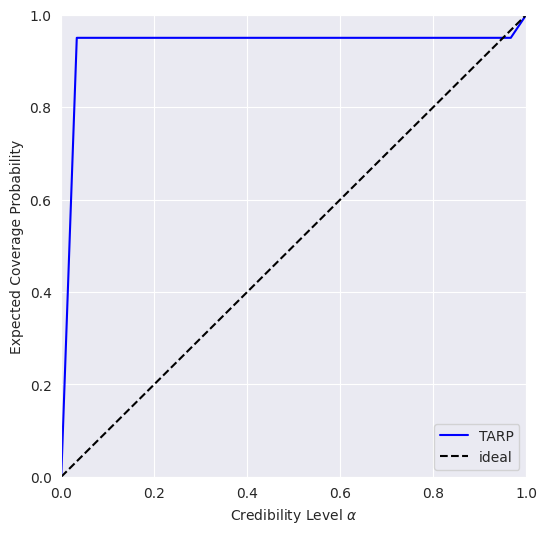

In [40]:
plot_tarp(ecp, alpha)
# plt.savefig("flux1_flow_pipeline_tarp.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()